In [1]:
import seagall as sgl
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import distinctipy
%matplotlib inline

2025-10-14 11:01:50,604 - INFO - CUDA available: 3087 MB free / 3906 MB total
2025-10-14 11:01:50,605 - INFO - ⚠️ Not enough free CUDA memory (3087 MB). Falling back to CPU.


Module seagall.base_dataset has been imported DEVICE --> cpu


In [2]:
adata=sc.read_h5ad("MouseBrain_GEX.h5ad")[:250, :250]
adata

View of AnnData object with n_obs × n_vars = 250 × 250
    obs: 'CellType'

In [3]:
sgl.ee.geometrical_graph(adata, target_label="CellType", path="SEAGALL")

2025-10-14 11:01:51,010 - INFO - Fitting GRAE
2025-10-14 11:01:51,010 - INFO - Fitting manifold learning method...


Calculating PHATE...
  Running PHATE on 213 observations and 250 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.23 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 0.32 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.35 seconds.
Calculated PHATE in 0.75 seconds.


2025-10-14 11:01:51,764 - INFO - Fitting encoder & decoder...
2025-10-14 11:01:51,980 - INFO - Epoch 10...
2025-10-14 11:01:52,185 - INFO - Epoch 20...
2025-10-14 11:01:52,394 - INFO - Epoch 30...
2025-10-14 11:01:52,576 - INFO - Epoch 40...
2025-10-14 11:01:52,755 - INFO - Epoch 50...
2025-10-14 11:01:52,775 - INFO - Model has been early stopped at epoch 50


In [4]:
adata

AnnData object with n_obs × n_vars = 250 × 250
    obs: 'CellType', 'target'
    uns: 'map', 'inv_map'
    obsm: 'GRAE_latent_space'
    obsp: 'GRAE_graph'

In [5]:
sgl.ee.explain(adata, target_label="CellType", path="SEAGALL", hypopt=0.25)

2025-10-14 11:01:57,288 - INFO - Tue Oct 14 11:01:57 2025 Checking for HPO file
2025-10-14 11:01:57,288 - INFO - Tue Oct 14 11:01:57 2025 Loading existing HPO results
2025-10-14 11:01:57,289 - INFO - Best lr: 0.010376572558743613
2025-10-14 11:01:57,289 - INFO - Best weight_decay: 0.001189744697489247
2025-10-14 11:01:57,289 - INFO - Best dim_h: 96
2025-10-14 11:01:57,290 - INFO - Best heads: 15
2025-10-14 11:01:57,290 - INFO - Best dropout: 0.30000000000000004
2025-10-14 11:01:57,290 - INFO - Tue Oct 14 11:01:57 2025 Creating dataset
2025-10-14 11:01:57,290 - INFO - Creating pyg dataset based on AnnData object with target label 'CellType' and GRAE's graph. Using 100% of the cells
2025-10-14 11:01:57,345 - INFO - Tue Oct 14 11:01:57 2025 Training model
2025-10-14 11:01:57,569 - INFO - Epoch 001: New best val F1 = 0.1540, model saved.
2025-10-14 11:01:57,764 - INFO - Epoch 002: New best val F1 = 0.2556, model saved.
2025-10-14 11:01:58,353 - INFO - Epoch 005: New best val F1 = 0.2628, m

In [6]:
adata

AnnData object with n_obs × n_vars = 250 × 250
    obs: 'CellType', 'target', 'SEAGALL_prediction', 'SEAGALL_set'
    var: 'SEAGALL_Importance_for_Deeper_Layer', 'SEAGALL_Importance_for_Ependymal_cells', 'SEAGALL_Importance_for_IPC', 'SEAGALL_Importance_for_RG_Astro_OPC', 'SEAGALL_Importance_for_Subplate', 'SEAGALL_Importance_for_Upper_Layer', 'SEAGALL_Importance_for_V_SVZ'
    uns: 'map', 'inv_map'
    obsm: 'GRAE_latent_space'
    layers: 'SEAGALL_Importance'
    obsp: 'GRAE_graph'

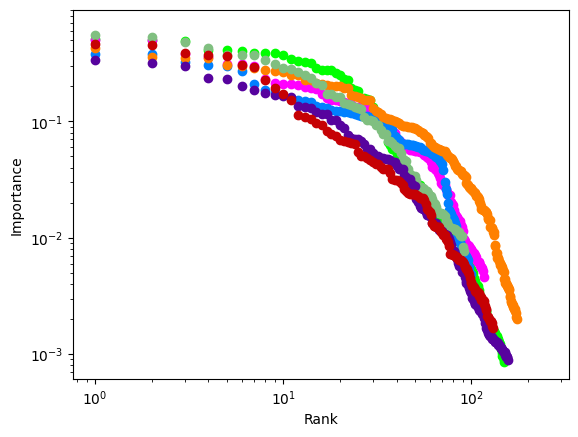

In [20]:
colors = distinctipy.get_colors(len(set(adata.obs.CellType)))
gts = {gt : c for gt, c in zip(sorted(list(set(adata.obs.CellType))), colors)}
for it in gts.items():
    plt.scatter(x=range(0, len(adata.var)), y=sorted(adata.var[f"SEAGALL_Importance_for_{it[0]}"])[::-1], c=it[1])
plt.xlabel("Rank")
plt.ylabel("Importance")
plt.xscale("log")
plt.yscale("log")

In [ ]:
adata=sc.read_h5ad("Test_Def.h5ad")
label="CellType"
adata

In [ ]:
mydata = sgl.mlu.create_pyg_dataset(adata, label)
mydata = torch_geometric.transforms.RandomNodeSplit(num_val=0.15, num_test=0.15)(mydata)

In [ ]:
model = sgl.mlu.GAT(n_feats=mydata.num_features, n_classes=mydata.num_classes).to(device)
optimizer_model = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(mydata.y), y=mydata.y.numpy())
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float), reduction="mean")
model, history = sgl.mlu.GAT_train_node_classifier(model, mydata, optimizer_model, criterion, "TEMP.pth", epochs=30, patience=5)

In [ ]:
adata.uns["GAT_history"]=history

In [ ]:
model.eval()
pred = model(mydata.x, mydata.edge_index).argmax(dim=1)

adata.obs["SEAGALL_set"] = "--"
adata.obs["SEAGALL_prediction"] = [adata.uns["inv_map"][str(num)] for num in list(pred.cpu().detach().numpy())]
adata.obs.loc[mydata.train_mask.cpu().detach().numpy(),"SEAGALL_set"] = "Train"
adata.obs.loc[mydata.val_mask.cpu().detach().numpy(),"SEAGALL_set"] = "Validation"
adata.obs.loc[mydata.test_mask.cpu().detach().numpy(),"SEAGALL_set"] = "Test"

In [ ]:
explainer = torch_geometric.explain.Explainer(
            model=model,
            algorithm=torch_geometric.explain.GNNExplainer(epochs=30),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=dict(mode='multiclass_classification', task_level='node', return_type='probs'))

In [ ]:
adata.layers["Importance"]=scipy.sparse.csr_matrix(explainer(x=mydata.x, edge_index=mydata.edge_index).node_mask.numpy(), dtype="float32")

In [ ]:
for gt in sorted(set(adata.obs[label])):
    imps = np.array(adata[adata.obs[label]==gt].layers["Importance"].mean(axis=0)).reshape(adata.shape[1], )
    adata.var[f"Importance_for_{gt}"] = imps

In [ ]:
n_feat=50
gts = sorted(set(adata.obs[label]))
jc = pd.DataFrame(index=gts, columns=gts)
for gti in gts:
    for gtj in gts[gts.index(gti)+1:]:
        fsi = adata[adata.obs[label]==gti].var[f"Importance_for_{gti}"].sort_values()[::-1][:int(n_feat)].index
        fsj = adata[adata.obs[label]==gtj].var[f"Importance_for_{gtj}"].sort_values()[::-1][:int(n_feat)].index
        jc.at[gti, gtj] = len(sgl.ut.intersection([fsi, fsj]))/len(sgl.ut.flat_list([fsi, fsj]))

In [ ]:
adata.uns[f"SEAGALL_Top_{n_feat}_Specificty"]=jc.values.astype()

In [ ]:
adata

In [ ]:
adata.write("Test_Def_All.h5ad", compression="gzip")

In [ ]:
pd.DataFrame.from_dict(adata.uns["GAT_history"]).melt()